In [1]:
import numpy as np
import pandas as pd
import os
import gzip

import matplotlib.pyplot as plt
from matplotlib import colors


# Functions

In [2]:
class BitReader(object):
    def __init__(self, f):
        self.input = f
        self.accumulator = 0
        self.bcount = 0
        self.read = 0

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    def _readbit(self):
        if not self.bcount:
            a = self.input.read(1)
            if a:
                self.accumulator = ord(a)
            self.bcount = 8
            self.read = len(a)
        rv = (self.accumulator & (1 << self.bcount-1)) >> self.bcount-1
        self.bcount -= 1
        return rv

    def readbits(self, n):
        v = 0
        while n > 0:
            v = (v << 1) | self._readbit()
            n -= 1
        return v

In [3]:
def bits2bytes(chaine):
    ent = int(chaine,2)
    byte_number = ent.bit_length() + 7 //8
    bin_array = ent.to_bytes(byte_number, "big")    
    return bin_array.decode() 

In [4]:
def tables_b(file_path):
    col_names_b = ['F', 'X', 'Y', 'Description', 'Unit', 'Scale', 'Reference_Value', 'Data_width_bits']
    dfb = pd.read_csv(file_path, sep = ';', header = None , names = col_names_b)
    return dfb

def tables_d(file_path):
    col_names_d = ['F', 'X', 'Y', 'dF', 'dX', 'dY']
    dfd = pd.read_csv(file_path, sep = ';', header = None, names = col_names_d)
    return dfd


In [5]:
def dico_descriptor_b(df0):
    dico_desc = {}
    for idx, row in df0.iterrows():
        dico_desc[str(row['F'])+"-"+str(row['X'])+"-"+str(row['Y'])] = {'Description' : row['Description'], 'Unit':row['Unit'], 'Scale': row['Scale'], 'Ref_Val':row['Reference_Value'], 'Data_width_bits':row['Data_width_bits']}
    return dico_desc
    

In [6]:
def dico_descriptor_d(df0):    
    key1 = ''
    dico_desc = {}
    listed = []
    for i in range(df0.shape[0]):        
        if df0.loc[i, 'F'][-1] == '3':   
            dico_desc[key1] = listed
            listed = []            
            key1 = '3-' + str(int(df0.loc[i, 'X'])) + '-' + str(int(df0.loc[i, 'Y']))
            listed = [str(int(df0.loc[i, 'dF'])) + '-' + str(int(df0.loc[i, 'dX'])) + '-' + str(int(df0.loc[i, 'dY']))]
        elif not(pd.isna(df0.loc[i,'dF'])):
            listed += [str(int(df0.loc[i, 'dF'])) + '-' + str(int(df0.loc[i, 'dX'])) + '-' + str(int(df0.loc[i, 'dY']))]
    dico_desc[key1] = listed
    return dico_desc

In [7]:
def bytes_desc(byt):
    if byt < 64:
        return '0-' + str(byt) + '-'
    elif byt < 128:
        return '1-' + str(byt-64) + '-'
    elif byt < 192:
        return '2-' + str(byt-128) + '-'
    else:
        return '3-' + str(byt-192) + '-'

In [8]:
def descri(desc, affiche):    
    if desc in dico_l_b:
        r=dico_l_b[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    elif desc in dico_l_d:
        r=dico_l_d[desc]
        if affiche:
            print(desc, ' : ',r )
        return r
        
    elif desc in dico_m_b:
        r=dico_m_b[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    elif desc in dico_m_d:
        r=dico_m_d[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    else:
        r='UNKNOWN'
        if affiche:
            print(desc, ' UNKNOWN')
        return r

In [9]:
def simple_desc(desc_elt):
    global  reader, compte, fin_affichage, affiche_descriptors, datas_total, last_description #datas_prob_rain, datas_height_rain, datas_horizon_refle
    descript_elt = descri(desc_elt, not(fin_affichage) and affiche_descriptors)
    if type(descript_elt) is dict:
        longueur = descript_elt['Data_width_bits'] + bit_width_plus
        description = descript_elt['Description']
        if not(fin_affichage) and affiche_descriptors:
            print('longueur : ', longueur, ' - Description : ', description)   
            
        tot_bits = reader.readbits(longueur)
        
        if bit_ref_changed:
            if desc_elt in bit_new_ref:
                val_data = (tot_bits + bit_new_ref[desc_elt])/10**(descript_elt['Scale']+bit_scale_plus)
            else:
                val_data = 0
                
        else:
            val_data = (tot_bits + descript_elt['Ref_Val'] )/10**(descript_elt['Scale']+bit_scale_plus)

        if compte==0:
            print('  "', bits2bytes(bin(tot_bits)), '"')
            
        elif not(fin_affichage) and affiche_descriptors:
                print('  = ', val_data, descript_elt['Unit'])
            
        if description in datas_total:
            datas_total[description] += [val_data]
        else:
            datas_total[description] = [val_data]

        # simplement pour ne pas tout afficher
        if description == last_description:
            fin_affichage = True
        else:
            fin_affichage = False

        last_description = description
        

# PROGRAM

In [11]:
# bufr file to decode
DIR_PATH = r'C:\Users\thepe\Documents\Data_Analyse\Meteo_France_API'
FILE_NAME = 'T_IMFR27_C_LFPW_20240124110000.bufr'
FILE_NAME = 'T_IMFR27_C_LFPW_20240126080000.bufr.gz'

# directory of the tables and local tables
DIR_PATH_TABLE = r'C:\Users\thepe\Documents\BUFR32\MeteoFranceTables'

# if you want to see all the descriptors (but lot of prints !!)
affiche_descriptors = False

In [12]:
FIC_TAB_B = 'bufrtabb_{master}.csv'
FIC_TAB_D = 'bufrtabd_{master}.csv'
FIC_LOCAL_TAB_B = 'localtabb_{center}_{local}.csv'
FIC_LOCAL_TAB_D = 'localtabd_{center}_{local}.csv'


In [13]:
FILE_PATH = os.path.join(DIR_PATH, FILE_NAME)
BYTES = 8
bits_data = ""
index_descript = 0
compte = 0
blocs_repetes  = 0
nb_repetitions = 0
bit_width_plus = 0
bit_scale_plus = 0
bit_new_ref = {}
bit_ref_changed = False
datas_total = {}
last_description = ''

fin_affichage = False

with gzip.open(FILE_PATH, 'rb') as infile: #with open(FILE_PATH, 'rb') as infile:
        with BitReader(infile) as reader:
            
            # IDENTIFICATION SECTION
            x = reader.readbits(4*BYTES)
            print(bits2bytes(bin(x)))
            x = reader.readbits(3*BYTES)                
            print('Total length of Bufr message in bytes : ', x)
            x = reader.readbits(1*BYTES)
            print('Bufr Edition number : ', x)
            
            # SECTION 1
            x = reader.readbits(3*BYTES)
            LENGTH_1 = x
            print('Length of section 1 : ', x)
            x = reader.readbits(1*BYTES)
            BUFR_MASTER_TABLE = x
            print('Bufr master table : ', x)
            x = reader.readbits(2*BYTES)
            CENTER_ID = x
            print('Identification of originating/generating centre : ', x)
            x = reader.readbits(2*BYTES)
            SUB_CENTER_ID = x
            print('Identification of originating/generating sub-centre : ', x)
            x = reader.readbits(1*BYTES)
            print('Update sequence number : ', x)
            x = reader.readbits(1*BYTES)
            print('Optional (1) / No Optional (0) section follows : ', x)
            x = reader.readbits(1*BYTES)
            print('Data Category (Table A) : ', x)
            x = reader.readbits(1*BYTES)
            print('International data sub-category : ', x)
            x = reader.readbits(1*BYTES)
            print('Local sub-category : ', x)
            x = reader.readbits(1*BYTES)
            MASTER_TABLE_NUMBER = x
            print('Version number of master table used : ', x)
            x = reader.readbits(1*BYTES)
            LOCAL_TABLE_NUMBER = x
            print('Version number of local tables used : ', x)

            # LOAD USEFUL TABLES
            try:
                table_b = tables_b(os.path.join(DIR_PATH_TABLE, FIC_TAB_B.format(master=MASTER_TABLE_NUMBER)))
                dico_m_b = dico_descriptor_b(table_b)
            except:
                print(' ** UNABLE TO READ MASTER TABLE B ** ')
                dico_m_b = {}
            try:
                table_d = tables_d(os.path.join(DIR_PATH_TABLE, FIC_TAB_D.format(master=MASTER_TABLE_NUMBER)))
                dico_m_d = dico_descriptor_d(table_d)
            except:
                print(' ** UNABLE TO READ MASTER TABLE D ** ')
                dico_m_d = {}
            try:
                local_table_b = tables_b(os.path.join(DIR_PATH_TABLE, FIC_LOCAL_TAB_B.format(center=CENTER_ID, local=LOCAL_TABLE_NUMBER)))
                dico_l_b = dico_descriptor_b(local_table_b)
            except:
                print(' ** UNABLE TO READ LOCAL TABLE B ** ')
                dico_l_b = {}
            try:
                local_table_d = tables_d(os.path.join(DIR_PATH_TABLE, FIC_LOCAL_TAB_D.format(center=CENTER_ID, local=LOCAL_TABLE_NUMBER)))
                dico_l_d = dico_descriptor_d(local_table_d)
            except:
                print(' ** UNABLE TO READ LOCAL TABLE D ** ')
                dico_l_d = {}
                
            x = reader.readbits(2*BYTES)
            print('Year : ', x)
            x = reader.readbits(1*BYTES)
            print('Month : ', x)
            x = reader.readbits(1*BYTES)
            print('Day : ', x)
            x = reader.readbits(1*BYTES)
            print('Hour : ', x)
            x = reader.readbits(1*BYTES)
            print('Minute : ', x)
            x = reader.readbits(1*BYTES)
            print('Second : ', x) 

            # OPTIONAL SECTION 2
            if LENGTH_1  > 22:
                x = reader.readbits((LENGTH_1 - 22)*BYTES)
                print('SECTION 2 : ', x)
            
            # SECTION 3 ( Data Description )
            x = reader.readbits(3*BYTES)
            LENGTH_3 = x
            print('Length of section 3 (Data Description) : ', x)
            x = reader.readbits(1*BYTES) # SET TO 0 (reserved)
            x = reader.readbits(2*BYTES)
            print('Number of data subsets : ', x)
            x = reader.readbits(1*BYTES)
            print('Observed/Compressed Data : ', x%2 , '/', x//2)
                
            # list of Descriptors
            descriptors = []
            desc = ''
                
            for i, k in enumerate(range(LENGTH_3 - 7)):
                x = reader.readbits(1*BYTES)
                if i%2 == 1:
                    desc += str(x)
                    descriptors += [desc]
                    desc = ''
                else:
                    desc = bytes_desc(x)

            if affiche_descriptors:
                print('Descriptors :')
                print(descriptors)

            # SECTION 4 ( Datas )
            x = reader.readbits(3*BYTES)
            LENGTH_4 = x
            print('Length of section 4 (Datas) : ', x)
            x = reader.readbits(1*BYTES) # SET TO 0 (reserved)

            while True:
                if index_descript >= len(descriptors):
                    print(' END OF DESCRIPTORS ')
                    break
                if not(fin_affichage) and affiche_descriptors:
                    print(descriptors[index_descript])
                    print(descriptors[index_descript][0])
                        
                if descriptors[index_descript][0] == '0':       
                    simple_desc(descriptors[index_descript])
                        
                elif descriptors[index_descript][0] == '3':        
                    descript_elt = descri(descriptors[index_descript], not(fin_affichage) and affiche_descriptors)
                    for eltk in descript_elt:
                        if affiche_descriptors:
                            print(eltk)
                        simple_desc(eltk)
                
                elif descriptors[index_descript][0] == '2':
                    new_ref = int(descriptors[index_descript].split('-')[2])        
                    if descriptors[index_descript].split('-')[1] == '1':            
                        if new_ref == 0:
                            bit_width_plus = 0
                        else:
                            bit_width_plus = new_ref - 128
                    if descriptors[index_descript].split('-')[1] == '2':            
                        if new_ref == 0:
                            bit_scale_plus = 0
                        else:
                            bit_scale_plus = new_ref - 128
                    if descriptors[index_descript].split('-')[1] == '3':
                        if 0 < new_ref:
                            bit_ref_changed = True
                            ybits = int(descriptors[index_descript].split('-')[2])
                            index_descript += 1
                            desc_new = descriptors[index_descript]
                            while desc_new != '2-3-255':
                                result = reader.readbits(ybits)
                                if result >= 2**(ybits-1):
                                    bit_new_ref[desc_new] = -1*(result - 2**(ybits-1))
                                else:
                                    bit_new_ref[desc_new] = result
                                index_descript += 1
                                desc_new = descriptors[index_descript]
                                
                        else:
                            bit_ref_changed = False                
                            bit_new_ref = {}
                
                elif descriptors[index_descript][0] == '1': 
                    print('* REPETITIONS *')
                    blocs_repetes = int(descriptors[index_descript].split('-')[1])
                    nbits_decal = descri(descriptors[index_descript+1], not(fin_affichage) and affiche_descriptors)['Data_width_bits']
                    nb_repetitions = reader.readbits(nbits_decal)
                    print('   number of descriptors replicated ', str(blocs_repetes), ' and number of replications = ', str(nb_repetitions))                        
                    descriptors = descriptors[:index_descript] + descriptors[index_descript+2: index_descript+2+blocs_repetes]*nb_repetitions + descriptors[index_descript+2+blocs_repetes:]
                    index_descript -= 1                               
                    
                index_descript += 1
                compte += 1

    
            print(" ** END OF DATAS **")            
            
            print('DATAS DESCRIPTORS NUMBER', len(datas_total))
            print('DATAS :')
            for key, value in datas_total.items():
                print(' ', key, ' : ',  len(value), ' data'+'s'*(len(value)>1) )                
                
            print(' END ')                 
            

                           BUFR
Total length of Bufr message in bytes :  9732846
Bufr Edition number :  4
Length of section 1 :  22
Bufr master table :  0
Identification of originating/generating centre :  85
Identification of originating/generating sub-centre :  0
Update sequence number :  0
Optional (1) / No Optional (0) section follows :  0
Data Category (Table A) :  6
International data sub-category :  0
Local sub-category :  27
Version number of master table used :  16
Version number of local tables used :  14
Year :  2024
Month :  1
Day :  26
Hour :  8
Minute :  0
Second :  0
Length of section 3 (Data Description) :  120
Number of data subsets :  1
Observed/Compressed Data :  0 / 64
Length of section 4 (Datas) :  9732692
  "                                                                                                                                                                                                                         Mosaique_metropole_Z_1km        "
* REPETIT

# MAPS

## Probability of Rain

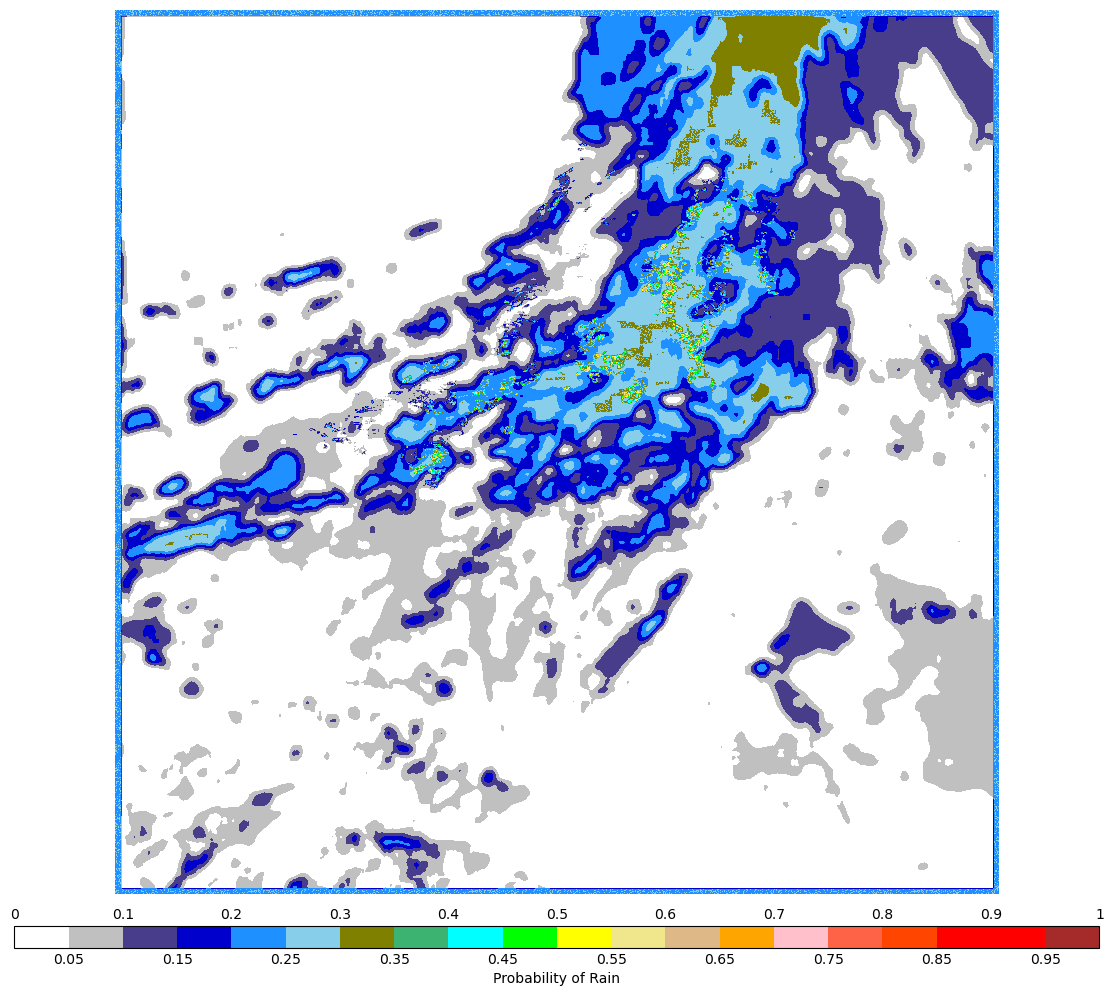

In [22]:
cmap_prob = colors.ListedColormap(['white','silver', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','pink','tomato', 'orangered', 'r', 'red', 'brown'])
bounds_prob = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
norm_prob = colors.BoundaryNorm(bounds_prob, cmap_prob.N)

ltop=bounds_prob[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_prob) ]
clabel_prob = 'Probability of Rain'

rows = int(datas_total['Number of pixels per row'][0])
cols = int(datas_total['Number of pixels per column'][0])

data1 = np.reshape(datas_total['Probability of rain'], (rows, cols))

fig, ax = plt.subplots(figsize=(14, 14))
fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_prob, norm=norm_prob)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_prob, norm=norm_prob, boundaries=bounds_prob, ticks=bounds_prob, location="bottom", pad=0.03, aspect=50)
cbar.set_label(clabel_prob)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
vmin=cbar.norm.vmin
vmax=cbar.norm.vmax
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_prob)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')

plt.savefig(FILE_NAME+'_prob_rain.jpg')

## Height

In [22]:
min(datas_total['Height']), max(datas_total['Height'])

(60.0, 40550.0)

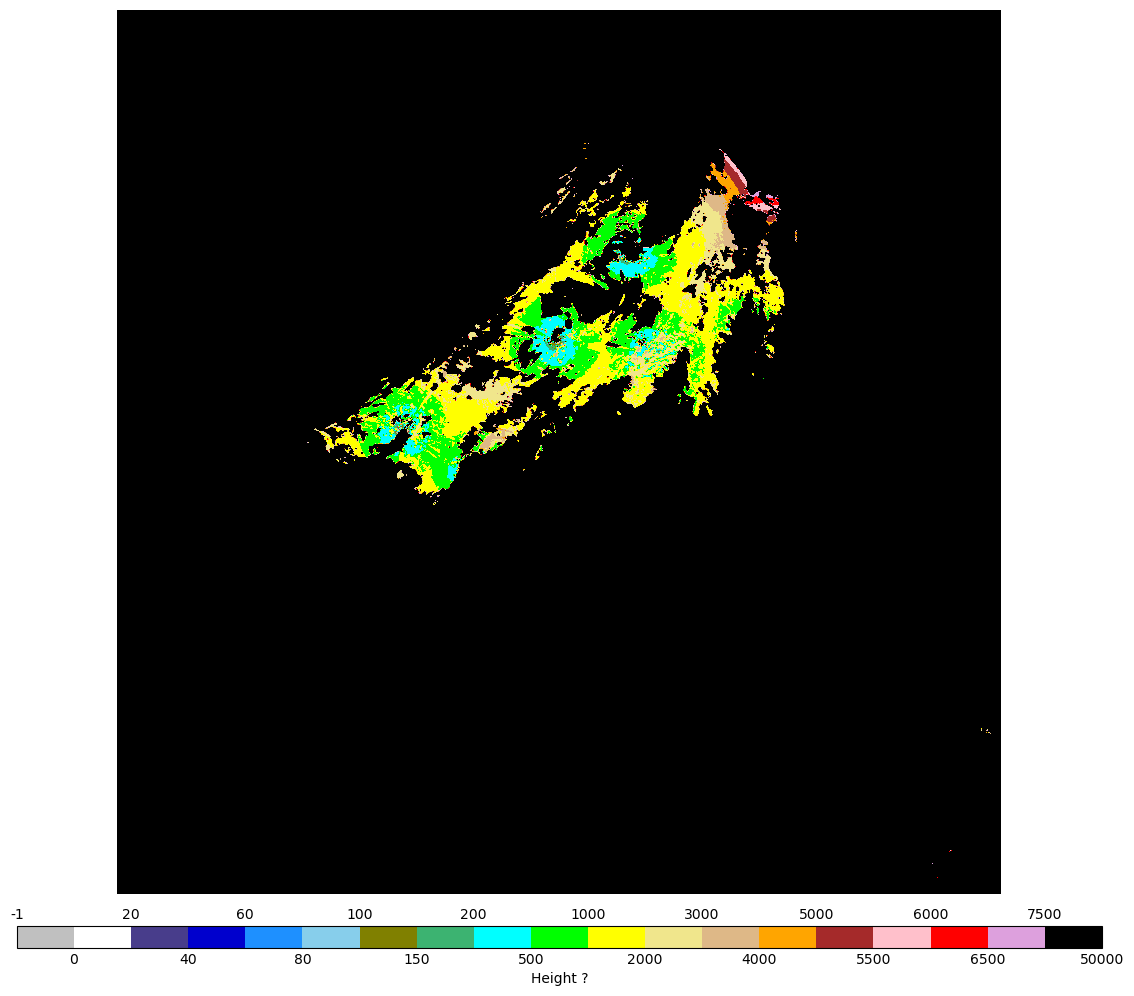

In [21]:
cmap_h = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_h = [-1, 0, 20, 40, 60, 80, 100, 150,200, 500,1000, 2000, 3000, 4000, 5000, 5500, 6000, 6500, 7500, 50000]
norm_h = colors.BoundaryNorm(bounds_h, cmap_h.N)


ltop=bounds_h[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_h) ]
clabel_h = 'Height ?'

rows = int(datas_total['Number of pixels per row'][0])
cols = int(datas_total['Number of pixels per column'][0])

data1 = np.reshape(datas_total['Height'], (rows, cols))

fig, ax = plt.subplots(figsize=(14, 14))
fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_h, norm=norm_h)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_h, norm=norm_h, boundaries=bounds_h, ticks=bounds_h, location="bottom", pad=0.03, aspect=50)
cbar.set_label(clabel_h)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
vmin=cbar.norm.vmin
vmax=cbar.norm.vmax
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_h)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')
    
plt.savefig(FILE_NAME+'_height.jpg')

## Horizontal Reflectivity

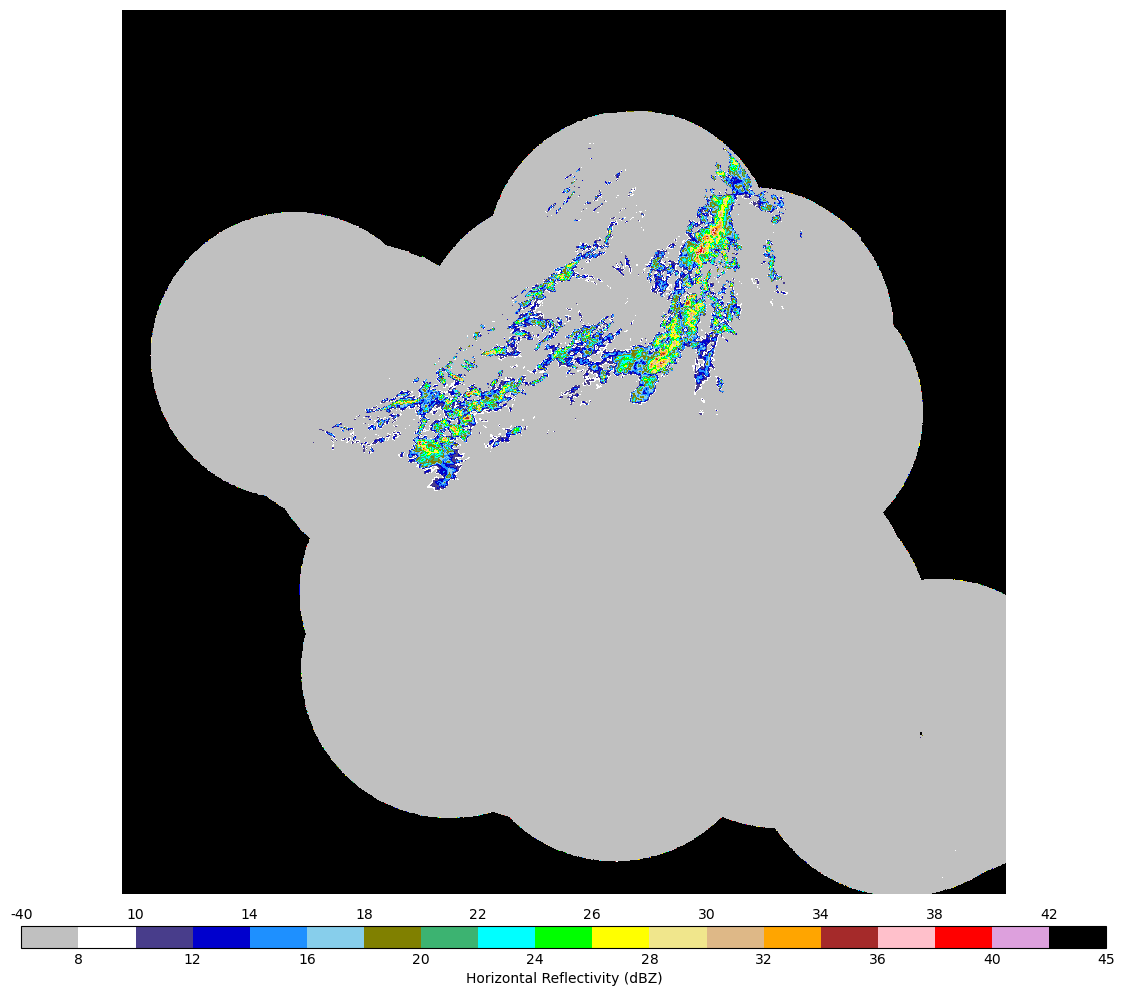

In [20]:
cmap_r = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_r = [-40, 8, 10, 12, 14,16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 45]
norm_r = colors.BoundaryNorm(bounds_r, cmap_r.N)


ltop=bounds_r[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_r) ]
clabel_r = 'Horizontal Reflectivity (dBZ)'

rows = int(datas_total['Number of pixels per row'][0])
cols = int(datas_total['Number of pixels per column'][0])

data1 = np.reshape(datas_total['Horizontal reflectivity'], (rows, cols))

fig, ax = plt.subplots(figsize=(14, 14))
fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_r, norm=norm_r)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_r, norm=norm_r, boundaries=bounds_r, ticks=bounds_r, location="bottom", pad=0.03, aspect=50)
cbar.set_label(clabel_r)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
vmin=cbar.norm.vmin
vmax=cbar.norm.vmax
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_r)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')

plt.savefig(FILE_NAME+'_dBZ.jpg'")